# Illustrations of the Phonlab library

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import librosa
import numpy as np
import seaborn as sns
import parselmouth
from IPython.display import Audio

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))
import phonlab as phon

import importlib
importlib.reload(phon)

print(phon.__name__,phon.__version__)
print(phon.get_timestamp_now())

phonlab 0.0.1
('2025-01-27T123554', '-0800')


In [2]:
import scipy.signal as sig
from pandas import DataFrame

def f0_from_harmonics(p,i,h):  
    ''' Assign harmonic numbers to the peaks in p
    
        p: an array of peak frequencies
        i: the starting peak to look at (0,n)
        h: the starting harmonic number to assign to this peak (1,n-1)
    '''
    m = np.zeros(len(p))
    f0 = []
    m[i] = h
    f0 = np.append(f0, p[i]/h)  # f0 if peak i is harmonic h
    thresh = 0.05 * f0[0]
    ex = 0  # number of harmonics over h=11

    h = h+1  # now look for the next harmonic

    for j in range(i+1,len(p)):  # step through the spectral peaks
        if abs((p[j]/h)-f0[0]) < thresh:  # close enough to be the next harmonic
            m[j] = h
            f0 = np.append(f0,p[j]/h)
            if (h>11): ex = ex + 1
            h=h+1
    C = ((h-1) + (len(p) - ex))/ np.count_nonzero(m)
    return C,np.mean(f0)

def get_f0_h(signal, f0_range = [60,400], fs_in= -1,chan = 0):

    down_fs = f0_range[1] * 6  # allow for 5 harmonics of the highest f0
    x, fs = phon.get_signal(signal, fs = down_fs, fs_in = fs_in, pre=0)  

    frame_length_sec = 1/f0_range[0]
    step_sec = 0.005
    N = 512    # FFT size

    frame_len = int(down_fs*0.04)  # forty ms frame
    step = int(down_fs*step_sec)  # stride between frames
    noverlap = frame_len - step   # points of overlap between successive frames

    while (frame_len > N): N = N * 2  # increase fft size if needed
    w = sig.windows.hamming(frame_len)
    f,ts,Sxx = sig.spectrogram(x,fs=fs,noverlap = noverlap, window=w, nperseg = frame_len, 
                              nfft = N, scaling = 'spectrum', mode = 'magnitude', detrend = 'linear')

    nb = len(ts)  # the number of frames (or blocks) in the LPC analysis
    f0 = np.empty(nb)
    rms = np.empty(nb)
    c = np.empty((nb))
    rms = 10* np.log10(np.sqrt(np.divide(np.sum(np.square(Sxx),axis=0),len(f))))
    print(rms.shape)
    
    min_dist = int(f0_range[0]/(down_fs/N)) # min distance btw harmonics
    min_height = 0.01 * np.max(Sxx)
    for idx in range(nb):
        peaks,props = sig.find_peaks(Sxx[:,idx], height = min_height, distance = min_dist)
        c[idx] = 50
        f0[idx] = np.nan
        if len(peaks)>2:  # we did find some harmonics
            for p in range(3):  # for each of the first three spectral peaks
                for h in range(1,4): # treat it as one of the first three harmonics
                    C,_f0 = f0_from_harmonics(f[peaks],p,h)
                    if C < c[idx]:  # keep the best peak/harmonic alignment
                        c[idx] = C
                        if C<3.5: f0[idx] = _f0
                        else:  f0[idx] = np.nan

    return DataFrame({'sec': ts, 'f0':f0, 'rms':rms[:nb], 'c':c[:nb]})



## phon.get_f0()

phon.formant_tracking() also returns measurements of the fundamental frequency of voicing (the f0), but you can also
use get_f0 to just return the f0 measurements.

Resampling from 16000 to 48000
Resampling from 16000 to 2400
(488,)


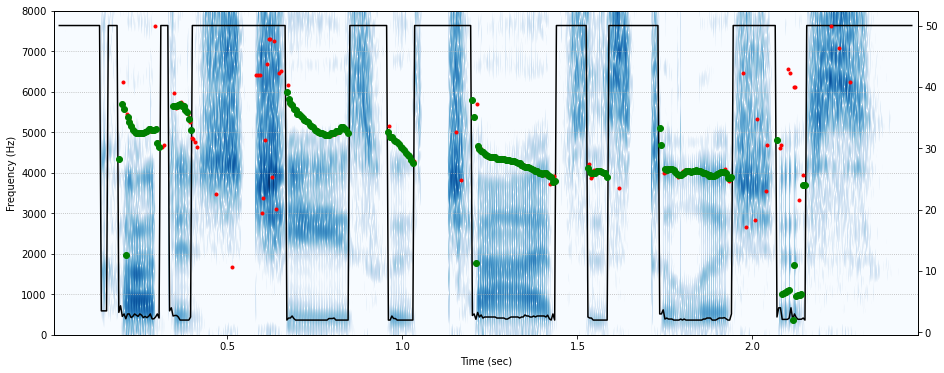

In [10]:

x,fs = phon.get_signal("sf3_cln.wav",pre= 0, fs=None)  # note pre=0 is important here
f0df = phon.get_f0_ac(x,fs_in=fs, f0_range=[63,300])
f0df.loc[f0df["voiced"] == False, ("f0")] = np.nan # ignore unvoiced frames

f0df_h = get_f0_h(x,fs_in=fs, f0_range= [63,400])

ret = phon.sgram(x,fs_in = fs,cmap='Blues') # draw the spectrogram from the array of samples
ax1 = ret[0]  # the first item returned, is the matplotlib axes object
ax2 = ax1.twinx()
#ax2.plot(f0df.sec,f0df.probv, 'k-')  # probability of voicing from 0 to 1
ax2.plot(f0df_h.sec, f0df_h.c, 'k-')
ax2.axes.yaxis.set_visible(True)

ax3 = ax1.twinx()
ax3.plot(f0df.sec, f0df.f0, 'r.')
ax3.plot(f0df_h.sec, f0df_h.f0, 'go')

ax3.axes.yaxis.set_visible(False)

## phon.sgram()

Makes a pretty good looking spectrogram

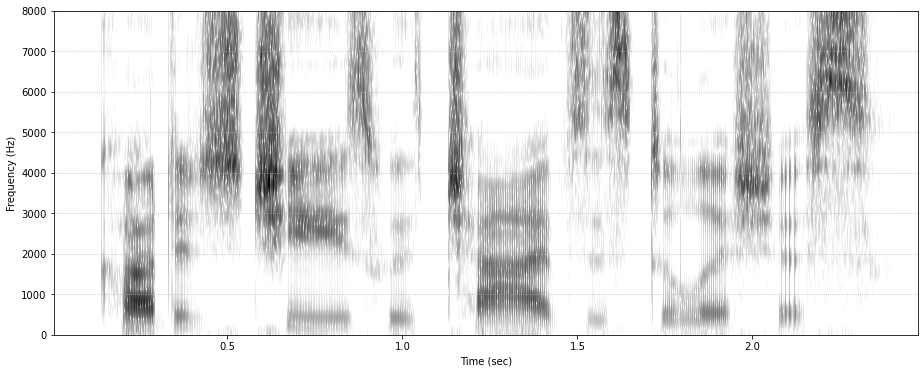

In [3]:
phon.sgram("sf3_cln.wav")
Audio("sf3_cln.wav")

## phon.amplitude_envelope()

Here's an intersting application of one of the phonab functions.  Get the amplitude envelope in a low frequency band, and then in a high frequency band.  The difference between them (plotted in red over the spectrogram below) divides the speech into consonant and vowel segments.  Above zero is 'sonorant' and below zero is 'non-sonorant'.

Resampling from 22050 to 16000


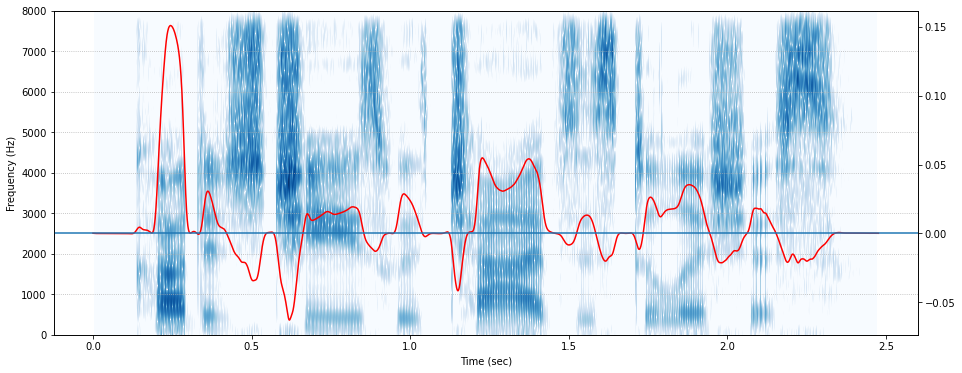

In [4]:
x,fs = phon.get_signal("sf3_cln.wav",pre= 0)  # note pre=0 is important here

lband, fs_diff = phon.amplitude_envelope(x,bounds=[120,1700],fs_in=fs, fs=16000)
hband, fs_diff = phon.amplitude_envelope(x,bounds=[3000,7999],fs_in=fs,fs=16000)

diff = lband-hband  # the difference in the low and high envelopes
time_axis = np.arange(len(diff))/fs_diff  # a time axis for envelope plotting

ax1,f,t,Sxx = phon.sgram(x,fs_in = fs,cmap='Blues') # draw the spectrogram from the array of samples

ax2 = ax1.twinx() # add a new y axis
ax2.plot(time_axis,diff, color = "red")  # plot the spectral balance "diff" function
ax2.axhline(0) # mark zero on the diff axis

Audio(x,rate=fs)  # note the use of the array and sampling rate from get_signal()

## phon.track_formants()

Python native code implements both LPC and Inverse Filter Control (IFC) vowel formant tracking.   Note how messy these vowel formant data look.  They will clean up very nicely with a little trick from the amplitude envelope funciton above.

LPC_tracking(), with order set to -1, and pitch range [63, 400]
Selected LPC order is: 10


sec        rms           F1           F2           F3           F4  \
0  0.01 -53.487625  1395.138373  2893.689097  5034.843159          NaN   
1  0.02 -56.174271  1244.283467  2894.009701  4201.520421  5313.027705   
2  0.03 -57.170086  1310.252966  2289.628642  3532.188676          NaN   
3  0.04 -53.818211  1777.429965  3016.006917  4227.837028  5380.319552   
4  0.05 -51.596817  2180.978227  4429.715182          NaN          NaN   

           f0         c  
0  102.564103  0.296168  
1  173.913043  0.343190  
2  108.108108  0.376746  
3  142.857143  0.330921  
4  285.714286  0.387689

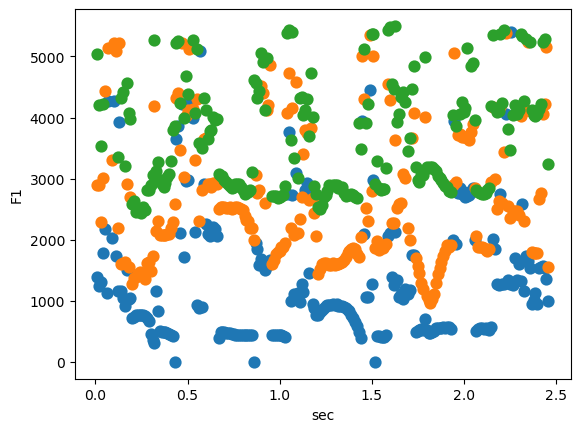

In [5]:
fmtsdf = phon.track_formants("sf3_cln.wav")

sns.pointplot(fmtsdf,x='sec',y='F1',linestyles='none', native_scale=True)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmtsdf.head()

### Sonorant

This code block uses the `diff[]` array plotted above to define a **sonorant** feature, 
and then uses that feature to clean up the formant plot.  This is really only needed for 
nice looking graphs.  We are also illustrating here the three main formant tracking methods in the package.  

This block also demonstrates how to use the 'tidypraat' function `formant2df()` to extract measurements from
a praat object and into a pandas dataframe.

LPC_tracking(), with order set to -1, and pitch range [120, 250]
Selected LPC order is: 10


<Axes: xlabel='Time (sec)', ylabel='Frequency (Hz)'>

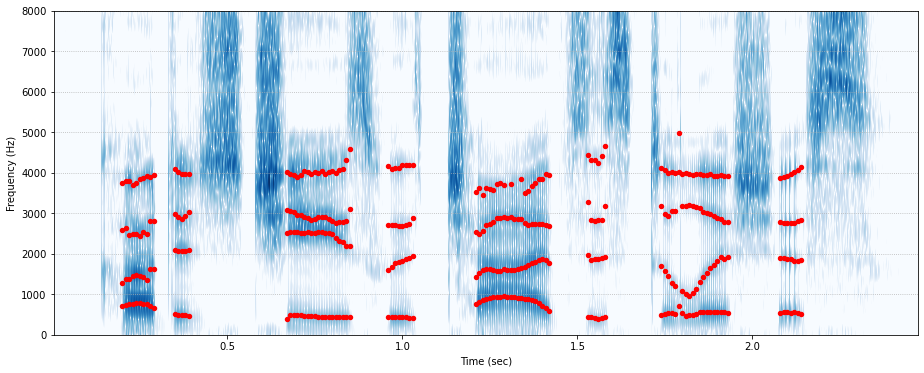

In [6]:
# 1) IFC formant tracking
#fmtsdf = phon.track_formants("sf3_cln.wav",method='ifc',speaker=1)

# 2) Python native LPC formant tracking
fmtsdf = phon.track_formants("sf3_cln.wav", f0_range = [120,250])

# 3) Praat LPC formant tracking
snd = parselmouth.Sound("sf3_cln.wav")  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
#fmtsdf = phon.formant2df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

# ------ use "vocalic" to decide which formant measurements to draw --------
x,fs = phon.get_signal("sf3_cln.wav",pre= 0)  # note pre=0 is important here
lband, fs_diff = phon.amplitude_envelope(x,bounds=[120,1700],fs_in=fs, fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,bounds=[3000,5999],fs_in=fs,fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
fmtsdf["son"] = diff[(fmtsdf['sec']*fs_diff).astype(int)]>0.005  # add 'vocalic' to the dataframe
fmtsdf.loc[fmtsdf["son"] == False, ("F1","F2","F3","F4")] = np.nan # ignore nonvocalic formants

phon.sgram("sf3_cln.wav", cmap="Blues")  # plot the spectrogram

# add formant dots to the spectrogram
dot_color = "red"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

sec           F1           F2           F3           F4  f0        spl
0  0.025906  1306.769820  2388.720107  3488.283346  4394.639375 NaN        NaN
1  0.032156  1443.269711  2406.732135  3513.311764  4443.028199 NaN  24.233068
2  0.038406  1606.757851  2623.228265  3179.217973  4291.317958 NaN  23.403752
3  0.044656  1740.477772  2081.097301  3339.921171  4417.462318 NaN  22.313753
4  0.050906  1382.584341  2251.298675  3497.364026  4435.417474 NaN  21.926261

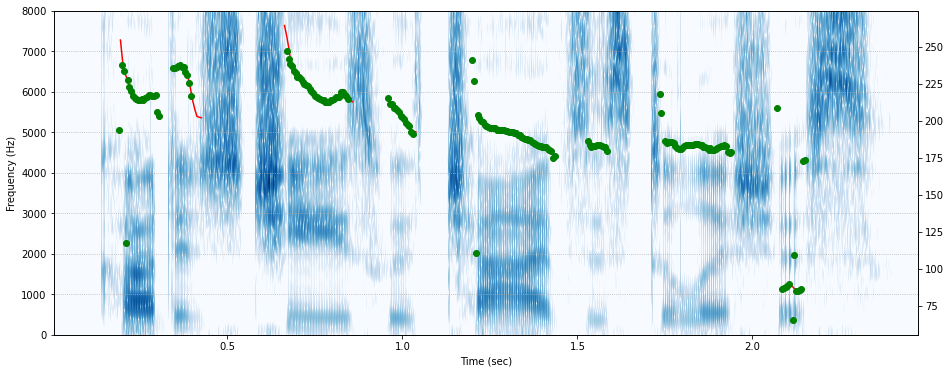

In [11]:
# 3) Praat LPC formant tracking
snd = parselmouth.Sound("sf3_cln.wav")  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
praat_fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmtsdf = phon.formant2df(praat_fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

praat_f0 = snd.to_pitch(pitch_floor=75,pitch_ceiling=300)
praatdf = phon.pitch2df(praat_f0,fmtsdf)

praat_intens = snd.to_intensity()
praatdf = phon.intensity2df(praat_intens,praatdf)  

ret = phon.sgram(x,fs_in = fs,cmap='Blues') # draw the spectrogram from the array of samples
ax1 = ret[0]  # the first item returned, is the matplotlib axes object
ax2 = ax1.twinx()
ax2.plot(praatdf.sec,praatdf.f0, 'r-')  # probability of voicing from 0 to 1
ax2.plot(f0df_h.sec, f0df_h.f0, 'go')

praatdf.head()

## phon.fricative()

Implements both major peak analysis and moments analysis.  The spectrum at time 0.635 (the 'ch' in 'cheese') illustrates that the "major peak" is the first well separated peak, not the point of maximum amplitude in the spectrum.

first major peak at 2950.0, Center of Gravity is 4765.6


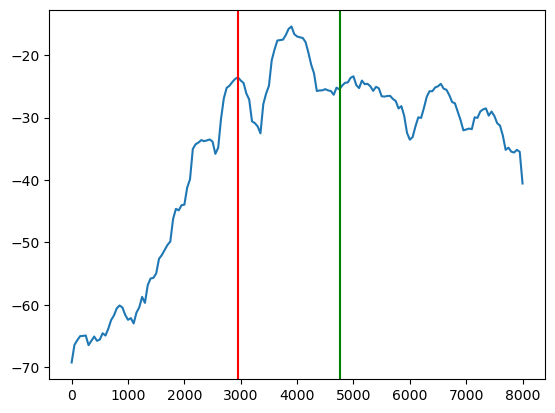

In [7]:
x,fs = phon.get_signal("sf3_cln.wav", pre=1,fs=None)

Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(x,0.635,fs)
print(f"first major peak at {Fm:.1f}, Center of Gravity is {COG:.1f}")
plt.plot(freq,spec)
plt.axvline(Fm,color="red")
plt.axvline(COG,color="green")

## phon.burst()

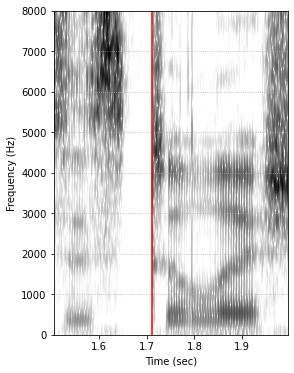

In [5]:
x,fs = phon.get_signal("sf3_cln.wav",pre=1)

t1 = 1.5
t2 = 2

b_time, b_score = phon.burst(x,t1,t2,fs)  # find a stop burst in the span from t1 to t2
#ret = phon.sgram("sf3_cln.wav",start=t1, end=t2,
#                         slice_time=b_time,preemph=0.96)

phon.sgram("sf3_cln.wav",start=1.5, end=2.0)
plt.axvline(b_time,color="red")

### phon.egg2oq()

With a stereo audio file having audio in the left (channel 0) and electroglottography in the right (channel 1),
this function returns a time axis, f0, and open quotient.


(140, 3) (2, 15876)


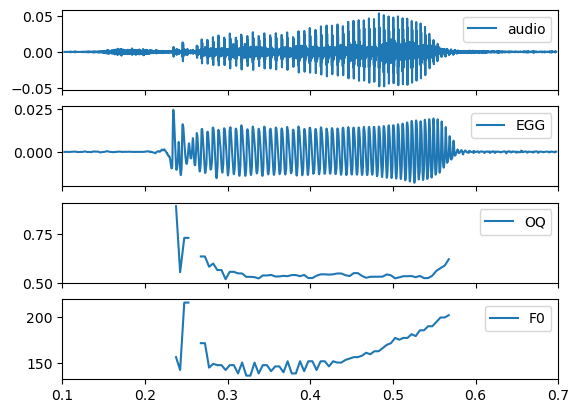

In [9]:
file = "F1_bha24_1.wav"  # a stereo file with audio in 0 and egg in 1

oqdf = phon.egg2oq(file,egg_channel=1)  # return open quotient data

# ------ The rest of this example is making a nice plot ---------
data, fs = librosa.load(file, mono=False)
audio = data[0]  
egg = data[1]

print(oqdf.shape, data.shape)

time = [i/fs for i in range(audio.size)]  # the times of the audio samples.

start_time = 0.1
end_time = start_time + 0.6

sf = np.abs(oqdf.sec - start_time).argmin()  # closest frame to start_time
ef = np.abs(oqdf.sec - end_time).argmin()      # closest frame to end_time

si = int(oqdf.sec.iloc[sf]*fs)  # index of those frame times
ei = int(oqdf.sec.iloc[ef]*fs)    # in the audio and egg signals

fig = plt.figure()
ax1 =fig.add_subplot(411)
ax1.plot(time[si:ei],audio[si:ei],label="audio")
ax1.set_xlim(start_time,end_time)
ax1.set_xticklabels(([]))
ax1.legend()

ax2 =fig.add_subplot(412,sharex=ax1)
ax2.plot(time[si:ei],egg[si:ei],label="EGG")
ax2.legend()

ax3 =fig.add_subplot(413,sharex=ax1)
ax3.plot(oqdf.sec.iloc[sf:ef],oqdf.OQ.iloc[sf:ef],label="OQ")
ax3.legend()

ax4 =fig.add_subplot(414)
ax4.plot(oqdf.sec.iloc[sf:ef],oqdf.f0.iloc[sf:ef],label="F0")
ax4.set_xlim(start_time,end_time)
ax4.legend()

Audio(audio,rate=fs)

# phon.Audspec()

Defines a class which includes a critical band filtering function that produces an auditory spectrogram.  There are also some functions to define and use filters to blur or sharpen the audiotory spectrogram.

1746.1000581238125

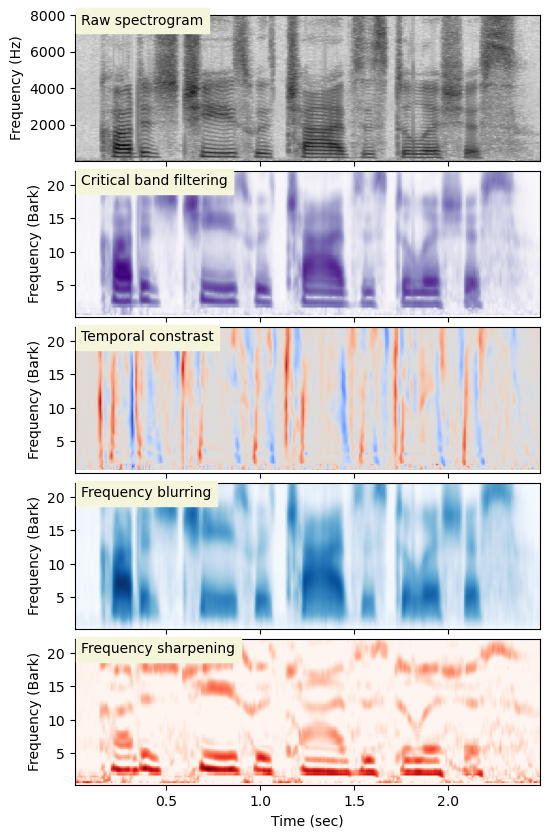

In [10]:
aud = phon.Audspec(fs=16000,step_size=0.01)
aud.make_zgram("sf3_cln.wav")
aud.make_sharpgram(span=6,mult=1)  # frequency sharpening
aud.make_blurgram(span=3, sigma=3)  # frequency blurring
aud.make_tgram()                    # temporal contrast, onsets and offsets

aud.savez('sf3_cln.aud.npz')  # save the auditory spectrogram along with all of the properties of the aud object.

d = np.load('sf3_cln.aud.npz', mmap_mode='r')  # get the data from the saved file
#for k in d.files: print(k)  # a list of all of the properties that are available in `d`

# ------------- plot spectrograms ------------
from mpl_toolkits.axes_grid1.axes_grid import Grid

fig = plt.figure(figsize=(6,10))
ax = Grid(fig, rect=111, nrows_ncols=(5, 1), axes_pad=0.1, label_mode='L')

 # we can use the saved/retrieved aud data in `d`, or we can use the data in the object `aud`
Hz_extent = (min(d["time_axis"]), max(aud.time_axis),
          min(aud.fft_freqs), max(aud.fft_freqs))  # get the time and frequency values for indices.

ax[0].imshow(20*np.log10(aud.sgram.T),origin='lower', aspect='auto', extent=Hz_extent, cmap = "Greys")
ax[0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
ax[1].imshow(d["zgram"].T,origin='lower', aspect='auto', extent=aud.extent, cmap = "Purples")
ax[1].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")
ax[2].imshow(aud.tgram.T, origin='lower', aspect='auto', extent=aud.extent, cmap = "coolwarm")
ax[2].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")
ax[3].imshow(aud.blurgram.T, origin='lower', aspect='auto', extent=aud.extent, cmap = "Blues")
ax[3].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")
ax[4].imshow(aud.sharpgram.T, origin='lower', aspect='auto', extent=aud.extent, cmap = "Reds")
ax[4].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

bgcolor = 'beige'
labelx = 0.05
ax[0].text(labelx,7500,'Raw spectrogram',backgroundcolor=bgcolor)
ax[1].text(labelx,20,'Critical band filtering',backgroundcolor=bgcolor)
ax[2].text(labelx,20,'Temporal constrast',backgroundcolor=bgcolor)
ax[3].text(labelx,20,'Frequency blurring',backgroundcolor=bgcolor)
ax[4].text(labelx,20,'Frequency sharpening',backgroundcolor=bgcolor)

aud.bark2hz(12)

## phon.sine_synth()

With a formants data frame from phon.track_formants(), sine_synth() produces sine wave analogs of speech.

LPC_tracking(), with order set to -1, and pitch range [63, 400]
Selected LPC order is: 10


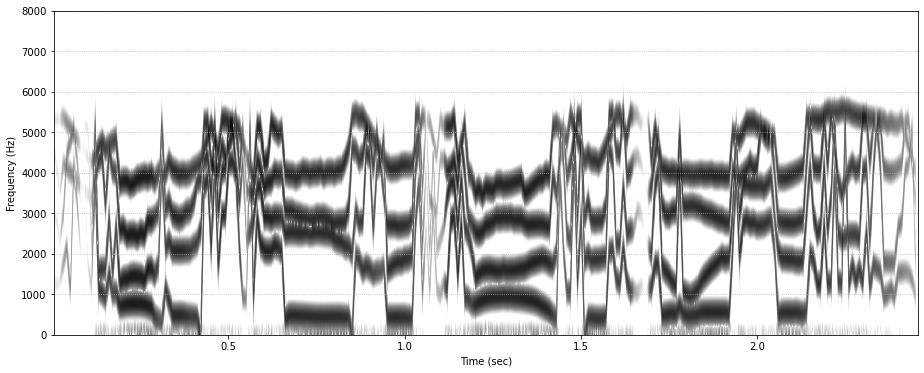

In [7]:
fmtsdf = phon.track_formants("sf3_cln.wav",fs_in=12000)    # track the formants

x2,fs2 = phon.sine_synth(fmtsdf)     # use the formants to produce sinewave synthesis
phon.sgram(x2,fs_in=fs2, preemph=0)  # plot a spectrogram of it

Audio(x2,rate=fs2) 

## phon.sigcor_noise()

Replace signal with noise that matches the amplitude envelope of the signal

Resampling from 22050 to 16000


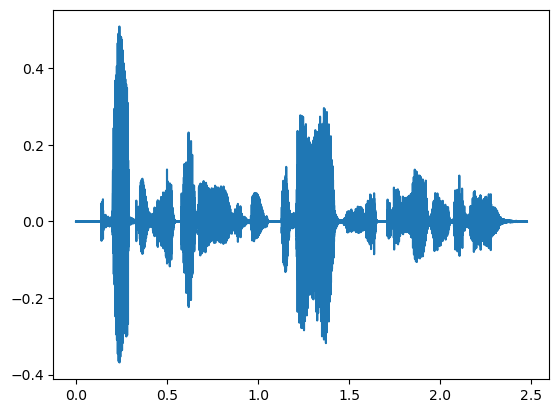

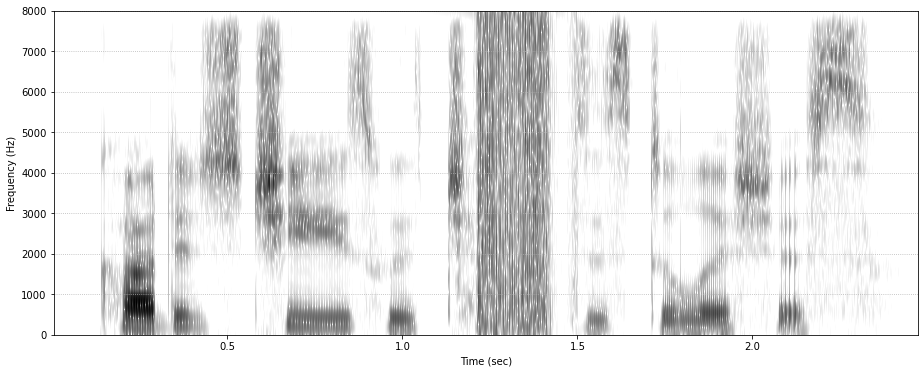

In [13]:
x,fs = phon.sigcor_noise("sf3_cln.wav",flip_rate=0.4,start=1.2,end=1.5)

time_axis = np.arange(len(x))/fs
plt.plot(time_axis,x)  # add_noise pads the signal by 0.5 seconds

phon.sgram(x,fs_in=fs,preemph=0)
Audio(x,rate=fs) 

## phon.add_noise()

A function that can be used to prepare speech in noise (SPIN) stimuli.


Resampling from 22050 to 16000


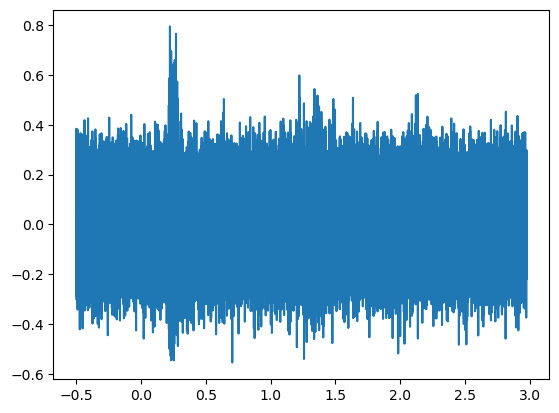

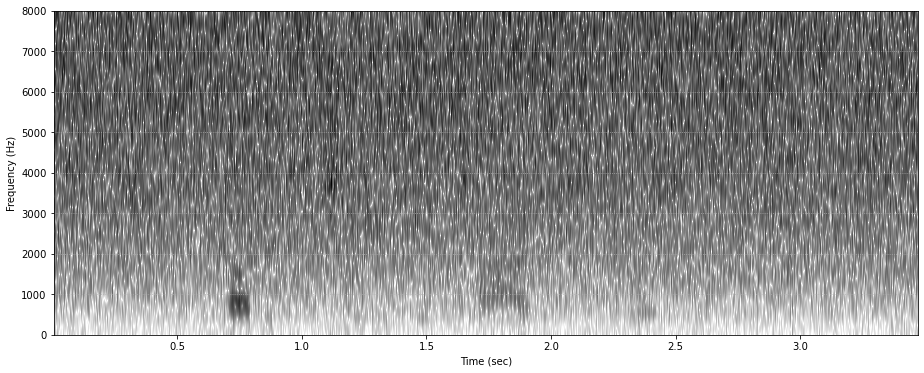

In [8]:
x,fs = phon.add_noise("sf3_cln.wav","white",snr=3)
time_axis = np.arange(len(x))/fs

plt.plot(time_axis - 0.5,x)  # add_noise pads the signal by 0.5 seconds
phon.sgram(x,fs_in=fs)
Audio(x,rate=fs) 

## phon.vocode()

Resynthesize speech with noise in frequency bands, simulating the amount of audio information in a cochlear implant.

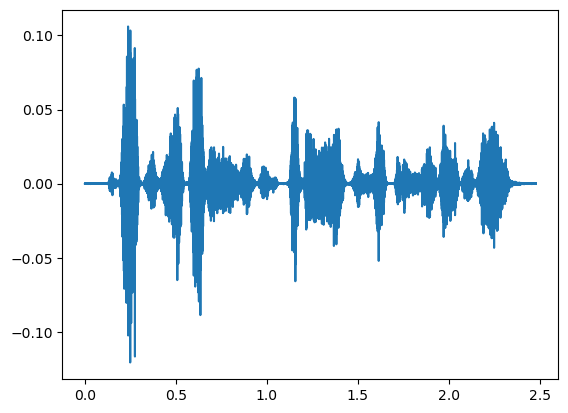

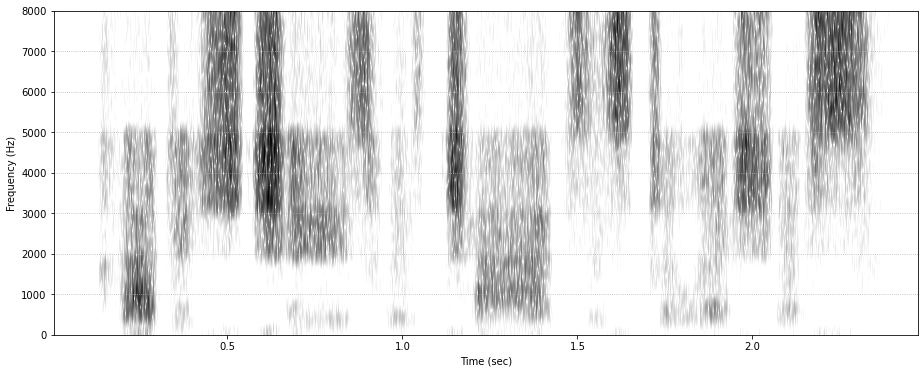

In [15]:
bands_third = phon.third_octave_bands(high=8000)  # define filter bank
bands_shan = phon.shannon_bands(high=8000,nc=10)  # define filter bank

y,fs = phon.vocode("sf3_cln.wav", bands_shan, fs=16000)  # use one of the filter banks

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)

phon.sgram(y,fs_in=fs)

Audio(y,rate=fs) 